In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartdisease/Heart_Disease_Prediction.csv


In [4]:
# Cell 1: Essential Imports & Google API Key Setup & Model Selection

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # For interacting with the operating system
import time # For retries in LLM API calls
import re # For simple text parsing

# ==============================================================================
# Google Generative AI Configuration
# ==============================================================================
# IMPORTANT: You might need to install this library if running locally or ensure it's available on Kaggle
# !pip install -U google-generativeai

import google.generativeai as genai
from kaggle_secrets import UserSecretsClient # For securely accessing API keys on Kaggle

# --- Google API Key Setup using Kaggle Secrets ---
# 1. Ensure you've added your API key to Kaggle Secrets:
#    - In your Kaggle notebook, click 'Add-ons' -> 'Secrets'.
#    - Click 'Add a new secret'.
#    - For 'Name', enter 'GOOGLE_API_KEY'.
#    - For 'Value', paste your actual Google API key.
#    - Check 'Attached' for this notebook.

try:
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
    print("Google API Key successfully loaded from Kaggle Secrets.")
except Exception as e:
    print(f"[!] Error loading Google API key from Kaggle Secrets: {e}")
    print("Please ensure you have added 'GOOGLE_API_KEY' as a secret in your Kaggle notebook.")
    GOOGLE_API_KEY = None # Set to None if key loading fails

if not GOOGLE_API_KEY:
    raise ValueError("Google API key not found. Please set it up in Kaggle Secrets to proceed.")

genai.configure(api_key=GOOGLE_API_KEY)

# --- List Available Models and Prompt for Selection ---
llm = None # Initialize llm to None
try:
    print("\n[*] Listing available Google Generative AI models...")
    all_models = genai.list_models()
    
    # Filter for models capable of 'generateContent' and exclude embeddings
    generative_models = []
    for m in all_models:
        if 'generateContent' in m.supported_generation_methods and 'embedding' not in m.name.lower():
            generative_models.append(m.name)
            
    if not generative_models:
        raise Exception("No suitable generative models found with 'generateContent' capability.")

    print("\nAvailable Generative Models (with 'generateContent' capability):")
    for i, model_name in enumerate(generative_models):
        print(f"  {i+1}. {model_name}")

    selected_model_name = None
    while selected_model_name not in generative_models:
        user_input = input(f"\nPlease enter the NAME of the model you want to use (e.g., 'gemini-pro' or 'gemini-1.5-flash'): ").strip()
        if user_input in generative_models:
            selected_model_name = user_input
        else:
            print(f"Invalid model name '{user_input}'. Please choose from the list above.")
            # Also check if it's a number and convert to name
            if re.match(r'^\d+$', user_input):
                try:
                    index = int(user_input) - 1
                    if 0 <= index < len(generative_models):
                        selected_model_name = generative_models[index]
                        print(f"You selected: {selected_model_name}")
                except ValueError:
                    pass # Handled by the generic 'Invalid model name'

    GEMINI_MODEL_NAME = selected_model_name
    llm = genai.GenerativeModel(GEMINI_MODEL_NAME)
    print(f"\nSuccessfully initialized Google Generative Model: {GEMINI_MODEL_NAME}")
    # A quick test to ensure it's working
    test_response = llm.generate_content("Hello, can you help with data analysis? (short response)")
    print(f"LLM Test Response: {test_response.text.strip().split('.')[0]}...")

except Exception as e:
    print(f"[!] Error during model selection or initialization: {e}")
    print("Setting LLM to None. The agent will operate without AI capabilities for questions/interpretations.")
    llm = None # Ensure llm remains None if initialization fails


# ==============================================================================
# Statistical & Visualization Libraries
# ==============================================================================
# These are also loaded here to be available for the agent class in the next cell
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO # For capturing df.info() output

Google API Key successfully loaded from Kaggle Secrets.

[*] Listing available Google Generative AI models...

Available Generative Models (with 'generateContent' capability):
  1. models/gemini-2.5-flash
  2. models/gemini-2.5-pro
  3. models/gemini-2.0-flash-exp
  4. models/gemini-2.0-flash
  5. models/gemini-2.0-flash-001
  6. models/gemini-2.0-flash-exp-image-generation
  7. models/gemini-2.0-flash-lite-001
  8. models/gemini-2.0-flash-lite
  9. models/gemini-2.0-flash-lite-preview-02-05
  10. models/gemini-2.0-flash-lite-preview
  11. models/gemini-exp-1206
  12. models/gemini-2.5-flash-preview-tts
  13. models/gemini-2.5-pro-preview-tts
  14. models/gemma-3-1b-it
  15. models/gemma-3-4b-it
  16. models/gemma-3-12b-it
  17. models/gemma-3-27b-it
  18. models/gemma-3n-e4b-it
  19. models/gemma-3n-e2b-it
  20. models/gemini-flash-latest
  21. models/gemini-flash-lite-latest
  22. models/gemini-pro-latest
  23. models/gemini-2.5-flash-lite
  24. models/gemini-2.5-flash-image-preview



Please enter the NAME of the model you want to use (e.g., 'gemini-pro' or 'gemini-1.5-flash'):  models/gemini-1.5-flash


Invalid model name 'models/gemini-1.5-flash'. Please choose from the list above.



Please enter the NAME of the model you want to use (e.g., 'gemini-pro' or 'gemini-1.5-flash'):  models/gemiini-2.5-flash-lite


Invalid model name 'models/gemiini-2.5-flash-lite'. Please choose from the list above.



Please enter the NAME of the model you want to use (e.g., 'gemini-pro' or 'gemini-1.5-flash'):  models/gemini-2.5-flash



Successfully initialized Google Generative Model: models/gemini-2.5-flash
LLM Test Response: Yes, I can...


In [5]:
# Cell 2: Statistical Insight Agent Class Definition

# IMPORTANT: This entire class definition must be in ONE code cell for Python's object-oriented structure to work.
# Each method relies on 'self' and other methods within the same class.

class StatisticalInsightAgent:
    def __init__(self, llm_model,
                 enable_llm_eda_summary=True,
                 enable_llm_question_generation=True,
                 enable_llm_hypothesis_building=True,
                 enable_llm_interpretation=True,
                 enable_llm_caption_generation=False): # Default to False to save tokens on plots
        self.df = None
        self.llm = llm_model
        if not self.llm:
            print("Warning: LLM not initialized. All LLM-dependent features will be disabled.")
            # If LLM failed to initialize, force all LLM flags to False
            self.enable_llm_eda_summary = False
            self.enable_llm_question_generation = False
            self.enable_llm_hypothesis_building = False
            self.enable_llm_interpretation = False
            self.enable_llm_caption_generation = False
        else:
            self.enable_llm_eda_summary = enable_llm_eda_summary
            self.enable_llm_question_generation = enable_llm_question_generation
            self.enable_llm_hypothesis_building = enable_llm_hypothesis_building
            self.enable_llm_interpretation = enable_llm_interpretation
            self.enable_llm_caption_generation = enable_llm_caption_generation

        # Configure plotting style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

    def _generate_llm_response(self, prompt, max_retries=3, delay=5):
        """Helper to get LLM response with basic retry logic."""
        if not self.llm:
            return "LLM not available. Please ensure it was initialized correctly in Cell 1."
        for attempt in range(max_retries):
            try:
                response = self.llm.generate_content(prompt)
                return response.text
            except Exception as e:
                print(f"LLM API Error (Attempt {attempt + 1}/{max_retries}): {e}")
                if attempt < max_retries - 1:
                    print(f"Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    return f"LLM API Error after {max_retries} attempts: {e}"
        return "Failed to get LLM response after multiple attempts."


    def load_data(self, file_path):
        """
        Loads a CSV file into a pandas DataFrame.
        """
        try:
            self.df = pd.read_csv(file_path)
            # Convert object columns that are clearly categorical to 'category' dtype
            for col in self.df.select_dtypes(include='object').columns:
                if self.df[col].nunique() / len(self.df) < 0.1 and self.df[col].nunique() < 50: # Heuristic for categorical
                    self.df[col] = self.df[col].astype('category')
            print(f"[*] Successfully loaded data from: {file_path}")
            print(f"    Shape: {self.df.shape}")
            return self.df
        except FileNotFoundError:
            print(f"[!] Error: File not found at {file_path}")
            self.df = None
            return None
        except pd.errors.EmptyDataError:
            print(f"[!] Error: The file {file_path} is empty.")
            self.df = None
            return None
        except Exception as e:
            print(f"[!] Error loading data: {e}")
            self.df = None
            return None

    def perform_eda(self):
        """
        Performs basic Exploratory Data Analysis and uses LLM to summarize.
        """
        if self.df is None:
            print("[!] No data loaded. Please load data first.")
            return

        print("\n" + "="*60)
        print("[*] Performing Basic Exploratory Data Analysis (EDA)")
        print("="*60)

        print("\n--- Dataset Info ---")
        self.df.info()

        print("\n--- Missing Values ---")
        missing_values = self.df.isnull().sum()
        print(missing_values[missing_values > 0].sort_values(ascending=False))
        if missing_values.sum() == 0:
            print("No missing values found.")

        print("\n--- Descriptive Statistics (Numerical) ---")
        print(self.df.describe().T)

        print("\n--- Value Counts (Top 10 for Categorical/Object Columns) ---")
        # Use 'category' dtype directly, as `load_data` converts objects heuristic-ally
        for col in self.df.select_dtypes(include=['object', 'category']).columns:
            print(f"- {col}:\n{self.df[col].value_counts().head(10).to_string()}")

        # LLM to summarize EDA (conditional)
        if self.llm and self.enable_llm_eda_summary:
            buffer_info = StringIO()
            self.df.info(buf=buffer_info)
            df_info_str = buffer_info.getvalue()

            eda_summary_prompt = f"""
            Analyze the following dataset information and provide a concise summary.
            Focus on:
            - Number of rows and columns.
            - General data types present.
            - Any significant missing values and their columns.
            - Key descriptive statistics (e.g., min/max/mean/std for numerical, common categories for categorical).
            - Potential insights or immediate observations about data quality or distributions.

            Dataset Info:
            {df_info_str}

            Missing Values:
            {missing_values[missing_values > 0].to_string() if not missing_values[missing_values > 0].empty else "No missing values."}

            Descriptive Statistics (Numerical):
            {self.df.describe().T.to_string()}

            Value Counts (Top 10 for Categorical/Object Columns):
            {'\n'.join([f'- {col}:\n{self.df[col].value_counts().head(10).to_string()}' for col in self.df.select_dtypes(include=['object', 'category']).columns])}
            """
            print("\n--- LLM Summary of EDA ---")
            llm_summary = self._generate_llm_response(eda_summary_prompt)
            print(llm_summary)
        elif self.llm and not self.enable_llm_eda_summary:
            print("\n--- LLM EDA Summary is DISABLED. ---")
        else:
            print("\n--- LLM not available for EDA summary. ---")

        return missing_values, self.df.describe()

    def generate_questions(self, num_questions=3):
        """
        Uses LLM to suggest statistical questions based on the dataset.
        """
        if self.df is None:
            print("[!] No data loaded. Cannot generate questions.")
            return []
        if not self.llm:
            print("[!] LLM not available. Cannot generate questions.")
            return []

        print("\n" + "="*60)
        print("[*] Generating Statistical Questions")
        print("="*60)

        if self.enable_llm_question_generation:
            df_description = self.df.head().to_string()
            column_info = "\n".join([f"- {col}: {self.df[col].dtype}" for col in self.df.columns])
            numerical_cols = self.df.select_dtypes(include=np.number).columns.tolist()
            categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

            prompt = f"""
            You are a data scientist. Given the following pandas DataFrame information,
            suggest {num_questions} relevant and insightful statistical questions that could be answered using this data.
            Focus on questions that involve comparing groups, looking for relationships/correlations,
            or identifying significant differences.
            Please try to explicitly mention 1-2 variables from the 'Dataset Columns' list in each question.

            DataFrame head:
            {df_description}

            Column Information (Name: Data Type):
            {column_info}

            Numerical Columns: {', '.join(numerical_cols)}
            Categorical Columns: {', '.join(categorical_cols)}

            Please format your output as a numbered list of questions, for example:
            1. Is there a relationship between [Variable1] and [Variable2]?
            2. Do [Group A] and [Group B] differ significantly in terms of [Numerical Variable]?
            """
            llm_questions_raw = self._generate_llm_response(prompt)
            print("LLM Suggested Questions:\n" + llm_questions_raw)

            questions = [q.strip() for q in llm_questions_raw.split('\n') if q.strip() and q.strip().startswith(tuple(str(i) + '.' for i in range(1, num_questions + 1)))]
            parsed_questions = []
            for q in questions:
                try:
                    parsed_questions.append(q.split('.', 1)[1].strip())
                except IndexError:
                    parsed_questions.append(q.strip())
            self.suggested_questions = parsed_questions
        else:
            print("\n--- LLM Question Generation is DISABLED. ---")
            print("To proceed, you would need to manually provide questions.")
            self.suggested_questions = [] # No questions if disabled
        return self.suggested_questions

    def build_hypotheses(self, question, variables):
        """
        Uses LLM to build Null and Alternative hypotheses for a given question.
        """
        if not self.llm:
            return "LLM not available for hypothesis generation."

        if self.enable_llm_hypothesis_building:
            print(f"\n--- Building Hypotheses for: \"{question}\" ---")
            prompt = f"""
            For the following statistical question, formulate a Null Hypothesis (H₀) and an Alternative Hypothesis (H₁).
            Be specific about the variables involved, referencing them from the provided list.

            Statistical Question: "{question}"
            Variables identified for this question: {', '.join(variables)}
            """
            hypotheses_raw = self._generate_llm_response(prompt)
            print(hypotheses_raw)
            return hypotheses_raw
        else:
            print(f"\n--- LLM Hypothesis Building is DISABLED for: \"{question}\" ---")
            return "Hypotheses generation disabled."

    def select_and_run_test(self, question, potential_variables, alpha=0.05):
        """
        Selects and runs an appropriate statistical test based on the question and variable types.
        This part uses a rule-based system for test selection.
        """
        if self.df is None:
            print("[!] No data loaded. Cannot run tests.")
            return None, None, "No data.", None, None, None
        # LLM not strictly required to run the statistical test, only for interpretation

        print(f"\n--- Selecting and Running Test for: \"{question}\" ---")
        print(f"    Potential variables from question: {potential_variables}")

        test_name = "Undetermined"
        p_value = None
        statistic = None
        effect_size = None
        interpretation = "Could not determine appropriate test or variables."
        plot_type = None
        variables_used_in_test = []

        available_vars = [v for v in potential_variables if v in self.df.columns]
        if not available_vars:
            interpretation = "None of the identified potential variables exist in the dataset."
            print(f"[!] {interpretation}")
            return test_name, p_value, interpretation, plot_type, variables_used_in_test, effect_size

        numerical_vars = [v for v in available_vars if pd.api.types.is_numeric_dtype(self.df[v])]
        # FIX: Replace pd.api.types.is_categorical_dtype with isinstance(series.dtype, pd.CategoricalDtype)
        categorical_vars = [v for v in available_vars if isinstance(self.df[v].dtype, pd.CategoricalDtype)]

        try:
            # 1. T-test / Mann-Whitney (Compare 2 groups on 1 continuous)
            if ('difference' in question.lower() or 'compare' in question.lower()) and len(numerical_vars) >= 1 and len(categorical_vars) >= 1:
                continuous_var = numerical_vars[0]
                group_var = categorical_vars[0]
                if self.df[group_var].nunique() == 2:
                    groups_data = [group.dropna() for name, group in self.df.groupby(group_var)[continuous_var]]
                    if len(groups_data) == 2 and all(len(g) > 1 for g in groups_data):
                        variables_used_in_test = [continuous_var, group_var]
                        plot_type = 'boxplot_two_groups'
                        normality_group1_p = stats.shapiro(groups_data[0])[1] if len(groups_data[0]) > 3 else 0
                        normality_group2_p = stats.shapiro(groups_data[1])[1] if len(groups_data[1]) > 3 else 0

                        if normality_group1_p > 0.05 and normality_group2_p > 0.05:
                            test_name = "Independent Samples T-Test"
                            statistic, p_value = stats.ttest_ind(groups_data[0], groups_data[1], equal_var=True)
                            diff_mean = groups_data[0].mean() - groups_data[1].mean()
                            pooled_std = np.sqrt(((len(groups_data[0])-1)*groups_data[0].std()**2 + (len(groups_data[1])-1)*groups_data[1].std()**2) / (len(groups_data[0])+len(groups_data[1])-2))
                            effect_size = diff_mean / pooled_std # Cohen's d
                            interpretation = f"Comparing the mean of '{continuous_var}' between the two groups of '{group_var}'."
                            print(f"    Selected: {test_name} (parametric)")
                        else:
                            test_name = "Mann-Whitney U Test"
                            statistic, p_value = stats.mannwhitneyu(groups_data[0], groups_data[1])
                            effect_size = abs(groups_data[0].median() - groups_data[1].median()) / self.df[continuous_var].std()
                            interpretation = f"Comparing the median of '{continuous_var}' between the two groups of '{group_var}' (non-parametric)."
                            print(f"    Selected: {test_name} (non-parametric)")

            # 2. ANOVA (Compare >2 groups on 1 continuous)
            if test_name == "Undetermined" and ('difference' in question.lower() or 'compare' in question.lower()) and len(numerical_vars) >= 1 and len(categorical_vars) >= 1:
                continuous_var = numerical_vars[0]
                group_var = categorical_vars[0]
                if self.df[group_var].nunique() > 2:
                    groups_data = [group.dropna() for name, group in self.df.groupby(group_var)[continuous_var]]
                    if all(len(g) > 1 for g in groups_data) and len(groups_data) == self.df[group_var].nunique():
                        variables_used_in_test = [continuous_var, group_var]
                        plot_type = 'boxplot_multiple_groups'
                        test_name = "One-Way ANOVA"
                        statistic, p_value = stats.f_oneway(*groups_data)
                        total_mean = self.df[continuous_var].mean()
                        ss_total = np.sum((self.df[continuous_var].dropna() - total_mean)**2)
                        ss_between = sum(len(group) * (group.mean() - total_mean)**2 for group in groups_data)
                        effect_size = ss_between / ss_total # Eta-squared
                        interpretation = f"Comparing the mean of '{continuous_var}' across multiple groups of '{group_var}'."
                        print(f"    Selected: {test_name}")

            # 3. Pearson Correlation (Relationship between 2 continuous)
            if test_name == "Undetermined" and ('correlation' in question.lower() or 'relationship' in question.lower() or 'relate' in question.lower()):
                if len(numerical_vars) >= 2:
                    num_var1, num_var2 = numerical_vars[0], numerical_vars[1]
                    temp_df = self.df[[num_var1, num_var2]].dropna()
                    if not temp_df.empty and len(temp_df) > 1:
                        variables_used_in_test = [num_var1, num_var2]
                        test_name = "Pearson Correlation"
                        statistic, p_value = stats.pearsonr(temp_df[num_var1], temp_df[num_var2])
                        effect_size = statistic
                        plot_type = 'scatterplot'
                        interpretation = f"Examining the linear correlation between '{num_var1}' and '{num_var2}'."
                        print(f"    Selected: {test_name}")

            # 4. Chi-square Test of Independence (Relationship between 2 categorical)
            if test_name == "Undetermined" and ('relationship' in question.lower() or 'association' in question.lower()):
                if len(categorical_vars) >= 2:
                    cat_var1, cat_var2 = categorical_vars[0], categorical_vars[1]
                    contingency_table = pd.crosstab(self.df[cat_var1], self.df[cat_var2])
                    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1 and contingency_table.sum().sum() > 0:
                        variables_used_in_test = [cat_var1, cat_var2]
                        test_name = "Chi-Square Test of Independence"
                        statistic, p_value, _, _ = stats.chi2_contingency(contingency_table)
                        n = contingency_table.sum().sum()
                        phi2 = statistic / n
                        r, k = contingency_table.shape
                        effect_size = np.sqrt(phi2 / min(r - 1, k - 1)) if min(r-1, k-1) > 0 else np.nan
                        plot_type = 'countplot_two_categorical'
                        interpretation = f"Investigating the association between '{cat_var1}' and '{cat_var2}'."
                        print(f"    Selected: {test_name}")

            # Output results before LLM interpretation
            print(f"    Test: {test_name}")
            print(f"    Statistic: {statistic:.4f}" if statistic is not None else "    Statistic: N/A")
            print(f"    P-value: {p_value:.4f}" if p_value is not None else "    P-value: N/A")
            print(f"    Effect Size: {effect_size:.4f}" if effect_size is not None and not np.isnan(effect_size) else "    Effect Size: N/A")

            # LLM Interpretation (conditional)
            if self.llm and self.enable_llm_interpretation and p_value is not None and test_name != "Undetermined":
                llm_prompt = f"""
                A {test_name} was performed to answer the question: "{question}".
                The test involved variables: {', '.join(variables_used_in_test)}.
                The calculated p-value is {p_value:.4f}.
                The test statistic is {statistic:.4f}.
                The calculated effect size (e.g., Cohen's d, Cramer's V, Pearson's r) is {effect_size:.4f}.
                Assume a significance level (alpha) of {alpha}.

                Please interpret these results in plain English.
                Specifically:
                1. State whether the null hypothesis should be rejected or failed to be rejected.
                2. Explain what the p-value means in this context.
                3. Explain the practical meaning of the results, considering the effect size.
                   For effect size guidelines (approximate):
                   - Cohen's d/Pearson's r: Small (<0.2), Medium (0.2-0.5), Large (>0.5).
                   - Cramer's V: Small (<0.1), Medium (0.1-0.3), Large (>0.3).
                   - Eta-squared: Small (~0.01), Medium (~0.06), Large (~0.14).
                4. Provide actionable insights if possible based on the significance and effect size.
                """
                llm_interpretation = self._generate_llm_response(llm_prompt)
                print("\n--- LLM Interpretation ---")
                print(llm_interpretation)
                interpretation = llm_interpretation
            elif p_value is not None:
                print("\n--- LLM Interpretation is DISABLED. ---")
                interpretation = f"P-value = {p_value:.4f}. If alpha={alpha}, then {'reject' if p_value < alpha else 'fail to reject'} the null hypothesis. (Detailed interpretation disabled)."


        except Exception as e:
            interpretation = f"An error occurred during test selection or execution: {e}"
            print(f"[!] {interpretation}")

        return test_name, p_value, interpretation, plot_type, variables_used_in_test, effect_size


    def generate_visualizations(self, plot_type, variables, test_name, p_value, effect_size, alpha=0.05):
        """
        Generates visualizations based on the test type and variables.
        """
        if self.df is None or not variables or plot_type is None:
            print("[!] No data or suitable variables to visualize.")
            return

        print("\n" + "="*60)
        print("[*] Generating Visualizations")
        print("="*60)

        fig, ax = plt.subplots(figsize=(10, 6))
        llm_caption = "A visual representation of the data relevant to the statistical test."

        try:
            if plot_type == 'boxplot_two_groups' and len(variables) == 2:
                continuous_var = [v for v in variables if pd.api.types.is_numeric_dtype(self.df[v])][0]
                group_var = [v for v in variables if v != continuous_var][0] # This assumes group_var is the other one
                sns.boxplot(x=group_var, y=continuous_var, data=self.df, ax=ax)
                ax.set_title(f'Distribution of {continuous_var} by {group_var}')
                ax.set_ylabel(continuous_var)
                ax.set_xlabel(group_var)
                if self.llm and self.enable_llm_caption_generation:
                    caption_prompt = f"""
                    Generate a concise caption (1-2 sentences) for a boxplot showing the
                    distribution of '{continuous_var}' across different groups of '{group_var}'.
                    Mention if there are apparent differences or overlaps and how it relates to the statistical test ({test_name}).
                    """
                    llm_caption = self._generate_llm_response(caption_prompt)

            elif plot_type == 'boxplot_multiple_groups' and len(variables) == 2:
                continuous_var = [v for v in variables if pd.api.types.is_numeric_dtype(self.df[v])][0]
                group_var = [v for v in variables if v != continuous_var][0]
                sns.boxplot(x=group_var, y=continuous_var, data=self.df, ax=ax)
                ax.set_title(f'Distribution of {continuous_var} across {group_var} Groups')
                ax.set_ylabel(continuous_var)
                ax.set_xlabel(group_var)
                if self.llm and self.enable_llm_caption_generation:
                    caption_prompt = f"""
                    Generate a concise caption (1-2 sentences) for a boxplot showing the
                    distribution of '{continuous_var}' across multiple groups of '{group_var}'.
                    Highlight any noticeable differences or trends relevant to the {test_name} test.
                    """
                    llm_caption = self._generate_llm_response(caption_prompt)

            elif plot_type == 'countplot_two_categorical' and len(variables) == 2:
                cat_var1, cat_var2 = variables[0], variables[1]
                sns.countplot(x=cat_var1, hue=cat_var2, data=self.df, ax=ax)
                ax.set_title(f'Count of {cat_var1} by {cat_var2}')
                ax.set_ylabel('Count')
                ax.set_xlabel(cat_var1)
                ax.legend(title=cat_var2)
                plt.xticks(rotation=45, ha='right')
                if self.llm and self.enable_llm_caption_generation:
                    caption_prompt = f"""
                    Generate a concise caption (1-2 sentences) for a countplot showing the
                    counts of '{cat_var1}' for different categories of '{cat_var2}'.
                    Point out any apparent patterns or distributions relevant to the {test_name} test.
                    """
                    llm_caption = self._generate_llm_response(caption_prompt)

            elif plot_type == 'scatterplot' and len(variables) == 2:
                num_var1, num_var2 = variables[0], variables[1]
                sns.scatterplot(x=num_var1, y=num_var2, data=self.df, ax=ax)
                ax.set_title(f'Scatter Plot of {num_var1} vs {num_var2}')
                ax.set_ylabel(num_var2)
                ax.set_xlabel(num_var1)
                if self.llm and self.enable_llm_caption_generation:
                    caption_prompt = f"""
                    Generate a concise caption (1-2 sentences) for a scatter plot showing the
                    relationship between '{num_var1}' and '{num_var2}'.
                    Comment on the direction, strength, or any outliers if visible, in the context of {test_name}.
                    """
                    llm_caption = self._generate_llm_response(caption_prompt)

            else:
                print(f"[!] No specific visualization for plot_type: {plot_type}. Attempting a general distribution plot.")
                if len(variables) > 0:
                    first_suitable_var = None
                    for var in variables:
                        if pd.api.types.is_numeric_dtype(self.df[var]):
                            first_suitable_var = var
                            break
                    if first_suitable_var:
                        sns.histplot(self.df[first_suitable_var].dropna(), kde=True, ax=ax)
                        ax.set_title(f'Distribution of {first_suitable_var}')
                        ax.set_xlabel(first_suitable_var)
                        ax.set_ylabel('Frequency')
                        if self.llm and self.enable_llm_caption_generation:
                            caption_prompt = f"""
                            Generate a concise caption (1-2 sentences) for a histogram showing the
                            distribution of '{first_suitable_var}'.
                            Mention its shape (e.g., normal, skewed) and any notable peaks or spread.
                            """
                            llm_caption = self._generate_llm_response(caption_prompt)
                    else:
                        print("[!] No suitable numerical variable found for a general histogram.")
                        plt.close(fig)
                        return
                else:
                    print("[!] No suitable variable for a general visualization.")
                    plt.close(fig)
                    return

            plt.text(0.02, -0.2, f"Figure Caption: {llm_caption}" if self.enable_llm_caption_generation else "Figure Caption: LLM caption generation disabled.", transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=0.5, alpha=0.5))
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"[!] Error generating visualization: {e}")
            plt.close(fig)

    def run_full_analysis(self, file_path, num_questions=2, alpha=0.05):
        """
        Orchestrates the entire statistical insight generation process.
        """
        if self.llm is None:
            print("[!] LLM not initialized. Cannot run full analysis.")
            return

        print("\n" + "="*80)
        print("          Starting Statistical Insight Agent Analysis          ")
        print("="*80)

        # 1. Load Data
        self.load_data(file_path)
        if self.df is None:
            print("[!] Analysis terminated due to data loading error.")
            return

        # 2. Perform Basic EDA
        self.perform_eda()

        # 3. Generate Statistical Questions
        suggested_questions = self.generate_questions(num_questions)

        if not suggested_questions and self.enable_llm_question_generation:
            print("[!] No questions generated. Analysis cannot proceed to tests.")
            return
        elif not suggested_questions and not self.enable_llm_question_generation:
            print("[!] LLM Question Generation is DISABLED. Please provide questions manually to proceed.")
            # You could add a mechanism here to accept manual questions if needed.
            # For now, if no questions, it stops.
            return


        for i, question in enumerate(suggested_questions):
            print(f"\n{'*'*70}\n[QUESTION {i+1}] {question}\n{'*'*70}")

            # Extract potential variables from the question (simple heuristic)
            potential_vars = []
            for col in self.df.columns:
                if col.lower() in question.lower() or col.replace('_', ' ').lower() in question.lower():
                    potential_vars.append(col)

            if not potential_vars:
                print(f"[!] Could not automatically identify relevant variables for question '{question}'. Skipping test.")
                continue
            else:
                print(f"    Agent identified potential variables for test: {', '.join(potential_vars)}")


            # 4. Build Hypotheses
            self.build_hypotheses(question, potential_vars)

            # 5. Select and Run Test
            test_name, p_value, interpretation, plot_type, variables_used, effect_size = \
                self.select_and_run_test(question, potential_vars, alpha)

            if test_name != "Error" and p_value is not None:
                print(f"\n--- Final Test Results for Question {i+1} ---")
                print(f"Test Performed: {test_name}")
                print(f"P-value: {p_value:.4f}")
                print(f"Effect Size: {effect_size:.4f}" if effect_size is not None and not np.isnan(effect_size) else "Effect Size: N/A")
                print(f"Decision (alpha={alpha}): {'Reject H₀' if p_value < alpha else 'Fail to Reject H₀'}")

                # 6. Generate Visualizations
                if plot_type and variables_used:
                    self.generate_visualizations(plot_type, variables_used, test_name, p_value, effect_size, alpha)
                else:
                    print("[!] No suitable plot type or variables identified for visualization.")
            else:
                print(f"\n[!] Could not perform statistical test for Question {i+1}: {interpretation}")

        print("\n" + "="*80)
        print("          Statistical Insight Agent Analysis Complete!          ")
        print("="*80)


--- Creating Dummy Dataset for Demonstration ---
Dummy dataset created at: /kaggle/working/student_performance.csv
Dummy dataset head:
   Student_ID  Gender  Study_Hours  Exam_Score Parental_Education  \
0           1    Male          8.0        82.0          Bachelors   
1           2  Female          8.0        66.0                PhD   
2           3    Male          9.0        82.0          Bachelors   
3           4  Female          5.0        73.0                PhD   
4           5    Male          7.0        89.0                PhD   

  Extracurricular  Attendance_Rate Internet_Access  
0             Yes        95.117505             Yes  
1             Yes        80.038232              No  
2             Yes        94.239485              No  
3              No        70.182954              No  
4              No        71.350760             Yes  

################################################################################
Running Sample Analysis with Dummy Data (Cell 3 O

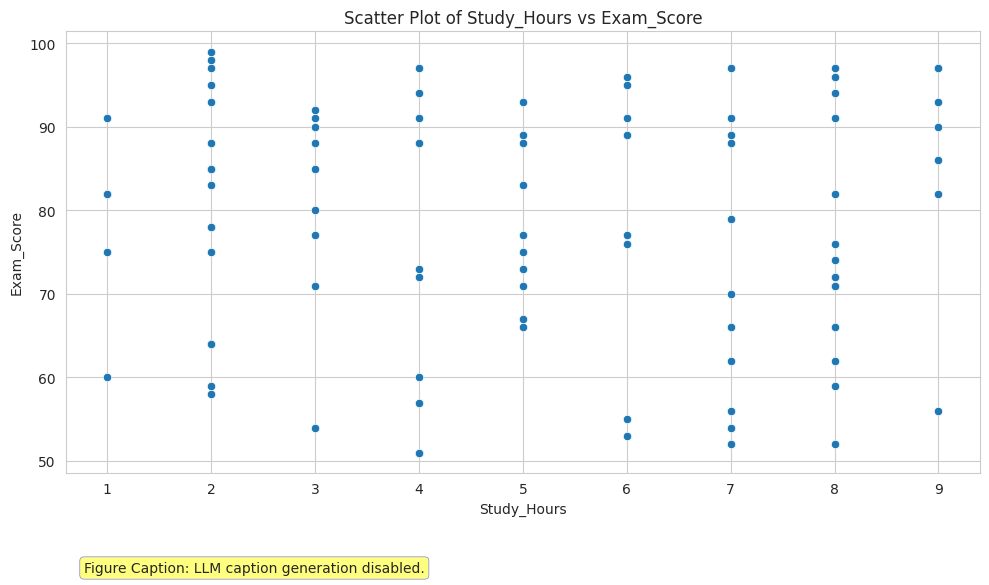


**********************************************************************
[QUESTION 2] Do students with different levels of `Parental_Education` backgrounds exhibit significantly different average `Exam_Score`s?
**********************************************************************
    Agent identified potential variables for test: Exam_Score, Parental_Education

--- Building Hypotheses for: "Do students with different levels of `Parental_Education` backgrounds exhibit significantly different average `Exam_Score`s?" ---
Here are the Null and Alternative Hypotheses for the given statistical question:

*   **Null Hypothesis (H₀):** There is no significant difference in the average `Exam_Score` among students with different levels of `Parental_Education` backgrounds.
    *(In other words, the average `Exam_Score` is the same for all levels of `Parental_Education`.)*

*   **Alternative Hypothesis (H₁):** Students with different levels of `Parental_Education` backgrounds exhibit significantly

In [6]:
# Cell 3: Dummy Data Creation and Initial Sample Analysis

print("\n--- Creating Dummy Dataset for Demonstration ---")
dummy_data = {
    'Student_ID': range(1, 101),
    'Gender': np.random.choice(['Male', 'Female'], 100),
    'Study_Hours': np.random.randint(1, 10, 100),
    'Exam_Score': np.random.randint(50, 100, 100),
    'Parental_Education': np.random.choice(['High School', 'Bachelors', 'Masters', 'PhD'], 100),
    'Extracurricular': np.random.choice(['Yes', 'No'], 100),
    'Attendance_Rate': np.random.uniform(70, 100, 100),
    'Internet_Access': np.random.choice(['Yes', 'No'], 100)
}
dummy_df = pd.DataFrame(dummy_data)

# Introduce some missing values for EDA
dummy_df.loc[np.random.choice(dummy_df.index, 5), 'Exam_Score'] = np.nan
dummy_df.loc[np.random.choice(dummy_df.index, 3), 'Study_Hours'] = np.nan

dummy_csv_path = '/kaggle/working/student_performance.csv'
dummy_df.to_csv(dummy_csv_path, index=False)
print(f"Dummy dataset created at: {dummy_csv_path}")
print(f"Dummy dataset head:\n{dummy_df.head()}")

# Instantiate the agent with custom LLM settings for the dummy data run
if llm: # Only run if LLM was successfully initialized
    print("\n" + "#"*80)
    print("Running Sample Analysis with Dummy Data (Cell 3 Output)")
    print("#"*80)
    
    # Example: Run with ALL LLM features ENABLED for a full demo (might use more tokens)
    # agent_full_llm = StatisticalInsightAgent(llm_model=llm,
    #                                          enable_llm_eda_summary=True,
    #                                          enable_llm_question_generation=True,
    #                                          enable_llm_hypothesis_building=True,
    #                                          enable_llm_interpretation=True,
    #                                          enable_llm_caption_generation=True)
    # agent_full_llm.run_full_analysis(dummy_csv_path, num_questions=2) # Use fewer questions for less token usage

    # Example: Run with essential LLM features ENABLED (questions, interpretation) and others DISABLED (more token-friendly)
    agent_limited_llm = StatisticalInsightAgent(llm_model=llm,
                                                enable_llm_eda_summary=False,         # Disable EDA summary by LLM
                                                enable_llm_question_generation=True,  # Keep question generation
                                                enable_llm_hypothesis_building=True,  # Keep hypothesis building
                                                enable_llm_interpretation=True,       # Keep interpretation
                                                enable_llm_caption_generation=False)  # Disable plot captions by LLM
    agent_limited_llm.run_full_analysis(dummy_csv_path, num_questions=2) # Fewer questions = fewer calls

else:
    print("\n[!] LLM could not be initialized in Cell 1. Skipping dummy data analysis.")

In [7]:
# Cell 4: Analyze Your Own CSV File

print("\n" + "="*80)
print("          Analyze Your Own CSV File          ")
print("="*80)

# ==============================================================================
# INSTRUCTIONS: How to use your own data on Kaggle
# ==============================================================================
# 1. Add your dataset to your Kaggle notebook:
#    - Click on the '+ Add data' button in the top right corner of the notebook.
#    - Search for your dataset or upload one.
#    - Once added, it will appear under the '/kaggle/input/' directory.
#
# 2. Update the 'your_csv_file_path' variable below:
#    - After adding your data, click on it in the 'Data' panel on the right.
#    - Copy the 'Path' it provides (e.g., /kaggle/input/my-cool-data/data.csv).
#    - Paste that path into the `your_csv_file_path` variable.
# ==============================================================================

# --- IMPORTANT: CHANGE THIS PATH TO YOUR ACTUAL CSV FILE ---
your_csv_file_path = '/kaggle/input/heartdisease/Heart_Disease_Prediction.csv' # EXAMPLE PATH
# Note: For the 'bank-marketing' dataset, you might need to specify the separator.
# To handle this, you'd modify the `load_data` method in Cell 2:
# e.g., self.df = pd.read_csv(file_path, sep=';')
# For this example, we'll assume default comma separation or a pre-processed file.

# --- Configure analysis parameters and LLM feature toggles for YOUR data ---
num_questions_to_generate = 2 # Control how many LLM questions are generated
alpha_significance_level = 0.05

# LLM Feature Toggles: Set these to True or False to control API usage
ENABLE_LLM_EDA_SUMMARY = False        # Set to True if you want LLM to summarize EDA
ENABLE_LLM_QUESTION_GENERATION = True # Set to True if you want LLM to suggest questions
ENABLE_LLM_HYPOTHESIS_BUILDING = True # Set to True if you want LLM to build hypotheses
ENABLE_LLM_INTERPRETATION = True      # Set to True if you want LLM to interpret test results
ENABLE_LLM_CAPTION_GENERATION = False # Set to True if you want LLM to generate plot captions


if not os.path.exists(your_csv_file_path):
    print(f"[!!!] WARNING: The file path '{your_csv_file_path}' does not exist.")
    print("       Please update `your_csv_file_path` in this cell with the correct path to your CSV dataset.")
elif llm:
    print(f"\n[*] Attempting to analyze your custom CSV: {your_csv_file_path}")
    print(f"    Agent will generate {num_questions_to_generate} questions and use alpha={alpha_significance_level}")
    print("\n" + "#"*80)
    print("Running Analysis with Custom Data (Cell 4 Output)")
    print("#"*80)

    # Instantiate agent with your chosen LLM feature toggles
    agent_custom_data = StatisticalInsightAgent(llm_model=llm,
                                                enable_llm_eda_summary=ENABLE_LLM_EDA_SUMMARY,
                                                enable_llm_question_generation=ENABLE_LLM_QUESTION_GENERATION,
                                                enable_llm_hypothesis_building=ENABLE_LLM_HYPOTHESIS_BUILDING,
                                                enable_llm_interpretation=ENABLE_LLM_INTERPRETATION,
                                                enable_llm_caption_generation=ENABLE_LLM_CAPTION_GENERATION)

    agent_custom_data.run_full_analysis(your_csv_file_path,
                                        num_questions=num_questions_to_generate,
                                        alpha=alpha_significance_level)
else:
    print("\n[!] LLM could not be initialized in Cell 1. Cannot perform analysis on your custom CSV.")


          Analyze Your Own CSV File          

[*] Attempting to analyze your custom CSV: /kaggle/input/heartdisease/Heart_Disease_Prediction.csv
    Agent will generate 2 questions and use alpha=0.05

################################################################################
Running Analysis with Custom Data (Cell 4 Output)
################################################################################

          Starting Statistical Insight Agent Analysis          
[*] Successfully loaded data from: /kaggle/input/heartdisease/Heart_Disease_Prediction.csv
    Shape: (270, 14)

[*] Performing Basic Exploratory Data Analysis (EDA)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      270 non-null    int64   
 1   Sex                      270 non-null    int64   
 2   Ch